In [1]:
GPU = False

In [2]:
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import cv2

In [3]:
path = Path("../")
data_path = path / "data"
train_images_path = data_path / "train_images"
test_images_path = data_path / "test_images"

# Dataframe

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


In [5]:
test_df = pd.read_csv(data_path / "test.csv")
test_df['path'] = test_df.id.apply(lambda x: f'{str(test_images_path)}/{x}.tiff')
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,path
0,10078,spleen,Hubmap,2023,2023,0.4945,4,../data/test_images/10078.tiff


# Functions

In [6]:
def mask2rle(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def maskPath2rle(img_path, rle):
    '''
    Funtion to probe if mask2rle is working
    '''
    img = cv2.imread(str(img_path), cv2.COLOR_BGR2RGB)
    mask = rle2mask(rle, img.shape)
    return mask2rle(mask)

def compare_rle(rle1, rle2):
    return rle1 == rle2

def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

def calc_mask(tensor, model):
    '''
    tensor: tensor of shape (1, 3, H, W)
    Returns mask of shape (H, W)
    '''
    if len(tensor.shape) == 3:
        tensor = tensor.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        if GPU:
            tensor = tensor.to(device)
        output = model(tensor).squeeze(0)
        pred_mask = torch.argmax(output, axis=0)
    return pred_mask.detach().cpu().numpy()

# Load model

In [7]:
model_name = "02_unet_custom_DataParallel.zip"
model_path = path / "models" / model_name
model = torch.jit.load(model_path)

# Sample

Obtenemos una imagen de muestra, la abrimos con opencv

In [8]:
idx = 2
sample_img_path = train_df.iloc[idx].path
sample_img_cv = cv2.imread(sample_img_path, cv2.COLOR_BGR2RGB)
type(sample_img_cv), sample_img_cv.shape, sample_img_cv.dtype, sample_img_cv.min(), sample_img_cv.max()

(numpy.ndarray, (3000, 3000, 3), dtype('uint8'), 10, 255)

Normalizamos la imagen

In [9]:
sample_img_cv_norm = sample_img_cv / 255.0
type(sample_img_cv_norm), sample_img_cv_norm.shape, sample_img_cv_norm.dtype, sample_img_cv_norm.min(), sample_img_cv_norm.max()


(numpy.ndarray, (3000, 3000, 3), dtype('float64'), 0.0392156862745098, 1.0)

Convertimos la imagen normalizada a un tensor

In [10]:
sample_img_tensor = torch.from_numpy(sample_img_cv_norm.astype(np.float32)).float().permute(2, 0, 1).unsqueeze(0)
type(sample_img_tensor), sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max()

(torch.Tensor,
 torch.Size([1, 3, 3000, 3000]),
 torch.float32,
 tensor(0.0392),
 tensor(1.))

Calculamos la máscara de la imagen de muestra mediante el modelo guardado

In [11]:
sample_mask_calc_np = calc_mask(sample_img_tensor, model)
type(sample_mask_calc_np), sample_mask_calc_np.shape, sample_mask_calc_np.dtype, sample_mask_calc_np.min(), sample_mask_calc_np.max()

(numpy.ndarray, (3000, 3000), dtype('int64'), 0, 1)

Ahora obtenemos la máscara a partir del rle de la muestra

In [12]:
sample_mask = rle2mask(train_df.iloc[idx].rle, sample_img_cv.shape)
type(sample_mask), sample_mask.shape, sample_mask.dtype, sample_mask.min(), sample_mask.max()

(numpy.ndarray, (3000, 3000), dtype('uint8'), 0, 1)

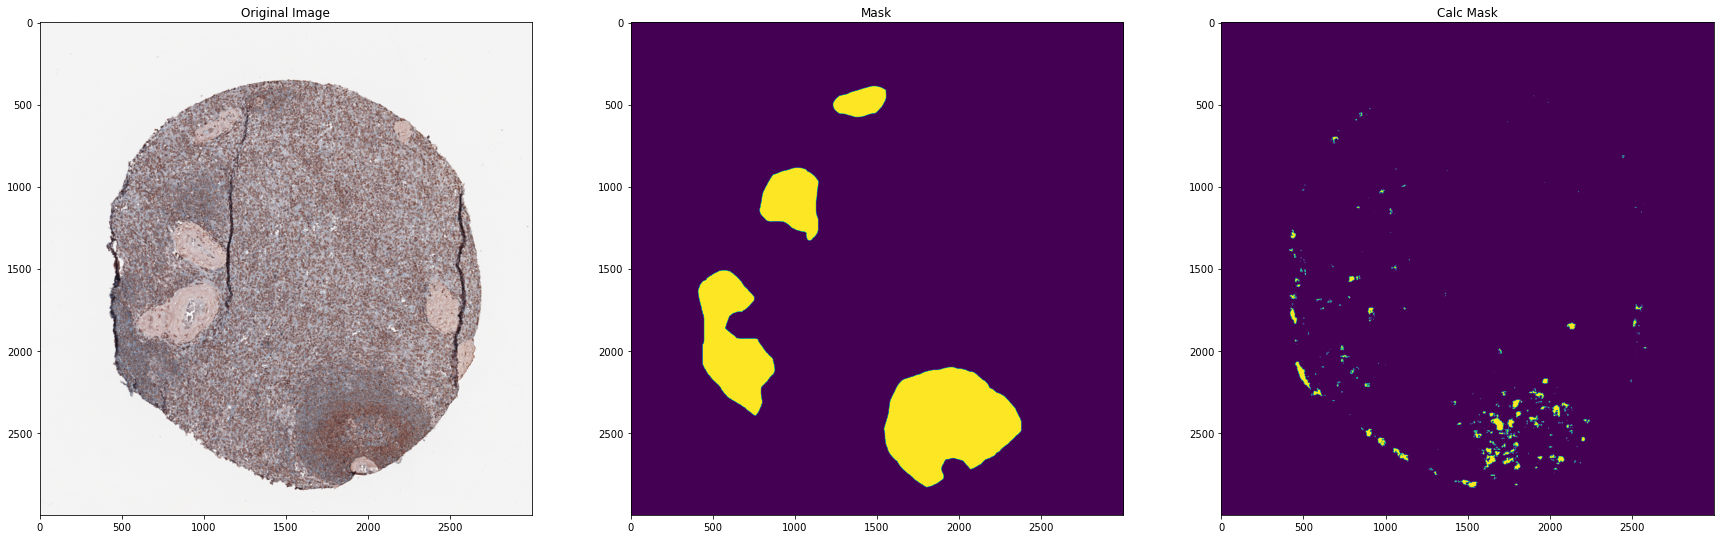

In [13]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv)
ax1.set_title('Original Image')
ax2.imshow(sample_mask)
ax2.set_title('Mask')
ax3.imshow(sample_mask_calc_np.squeeze())
ax3.set_title('Calc Mask')
plt.show()

# Create function

In [14]:
def calc_mask_from_image_path(img_path, model):
    '''
    img_path: path to image
    model: model to use for inference
    Returns mask of shape (H, W)
    '''
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB) / 255.0
    img_tensor = torch.from_numpy(img.astype(np.float32)).float().permute(2, 0, 1).unsqueeze(0)
    return calc_mask(img_tensor, model)

def calc_rle_from_image_path(img_path, model):
    '''
    img_path: path to image
    model: model to use for inference
    Returns rle string
    '''
    mask = calc_mask_from_image_path(img_path, model)
    return mask2rle(mask)

In [15]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


In [16]:
# Subset of train_df with first 10 images
train_df_subset = train_df.iloc[:10]
train_df_subset.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


In [17]:
train_df_subset['rle_calc'] = train_df_subset.apply(lambda x: calc_rle_from_image_path(x.path, model), axis=1)
train_df_subset.head()

/tmp/ipykernel_37537/3266501079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_subset['rle_calc'] = train_df_subset.apply(lambda x: calc_rle_from_image_path(x.path, model), axis=1)


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path,rle_calc
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff,955526 1 958525 3 961525 3 964483 1 964525 3 9...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff,598535 3 601530 8 604528 10 607530 8 610531 7 ...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff,1246385 4 1249384 6 1252384 6 1255384 7 125566...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff,1840925 2 1891964 2 1894963 3 2033072 5 203606...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff,235533 1 238531 8 241530 10 241593 2 244517 4 ...


# Try GPU

In [18]:
GPU = True

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
if torch.cuda.is_available():
    print("Using GPU")

Using GPU


In [20]:
test_df['rle'] = test_df.apply(lambda x: calc_rle_from_image_path(x.path, model), axis=1)
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,path,rle
0,10078,spleen,Hubmap,2023,2023,0.4945,4,../data/test_images/10078.tiff,8305 4 9672 3 10321 13 10765 10 10983 6 11692 ...
